## FFT 1D with the Emulsion phase pattern

 author : Sylvie Dagoret-Campagne
- aflilation IJCLab/IN2P3/CNRS
- creation date 2025-01-18
- doc on FFT : https://numpy.org/doc/2.0/reference/generated/numpy.fft.fft.html
- conda environnement : poppy_conda_py312 (on my macbook)
- install poppy : https://poppy-optics.readthedocs.io/en/latest/
- install rise in jupyterlab to see the slides : https://github.com/jupyterlab-contrib/rise
- install pandoc for documentation

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import astropy.units as u
from scipy.integrate import quad

In [2]:
from auxtelpsfpoppy.libholotransmission import *

In [3]:
import matplotlib as mpl

mpl.rcParams['lines.linewidth'] = 2
mpl.rcParams['lines.linestyle'] = '-'
mpl.rcParams['axes.titlesize'] =  24
mpl.rcParams['axes.labelsize'] =  20
mpl.rcParams['lines.markersize'] =  10
mpl.rcParams['xtick.labelsize'] =  16
mpl.rcParams['ytick.labelsize'] = 16

## Introduction

### Diffraction of a parallel beam by a 1D aperture $x_1$ seen on a screen at $x_0$ 

We approximate the diffraction by an optical element with the 1D approximation, with the $x$ axis as the transverse coordinalte and the $z$ axis the wave propagation axis.
Taking the formula from the Goodman book we get the formula:

- in Fresnel approximation (spherical wave $\rightarrow$ quadratic terms in propagation term $\frac{e^{ikr_{01}}}{j\lambda z}$~:$z^3 \gg \frac{\pi}{4\lambda}\left(x_0-x_1\right)^4|_{max} $:
$$
U(x_0) = \frac{exp(jkz)}{jkz} \exp\left(j \frac{k}{2z}x_0^2 \right) \int \int \left\{ U(x_1) \exp\left(  j \frac{k}{2z}x_1^2\right)\right\} \times \exp \left\{ -j \frac{2 \pi}{\lambda z}x_0\cdot x_1
\right\}dx_1 
$$
- in Fraunhofer approximation $ z \gg \frac{k(x_1^2+y_1)}{2}|_{max}$:
$$
U(x_0) = \frac{exp(jkz)}{jkz} \exp\left(j \frac{k}{2z}x_0^2 \right) \int \int  U(x_1)  \times \exp \left\{ -j \frac{2 \pi}{\lambda z}x_0\cdot x_1
\right\}dx_1 
$$
- The Fraunhofer approximation solution is proportional to the Fourier transform of $U(x_1)$ at frequency $f_X = \frac{x_0}{\lambda z} = \frac{\tan \alpha}{\lambda }$
- The Fresnel approximation solution is proportional to the Fourier transform of $\left \{ U(x_1) \cdot \exp\left(  j \frac{k}{2z}x_1^2\right) \right\}$ at frequency $f_X = \frac{x_0}{\lambda z} = \frac{\tan \alpha}{\lambda }$
- $ \alpha$ is the incident angle on the focal line  in the $(X-Z)$ plane.

### Transform the parallel beam into a converging beam

- thin lens of focal length $\phi$ with a transmission function (depending on lens depth $\Delta_0$ and refractive index $n$):
$$
U_l(x) = \exp(j k\Delta_0 n) \cdot \exp(-j \frac{k}{2\phi}x^2)
$$
- When a lens (or mirror) transform a parallel beam into a converging beam at the location of an object and have a screen at the focal plane, the $\exp \left(j \frac{k}{2z}x_1^2 \right)$ is compensated by the lens term $\exp(-j \frac{k}{2\phi}x^2)$
- Thus a  converging lens (or mirror) transform a parallel beam Fresnel diffraction into a Fraunhofer diffraction, provided $z=\phi$.
$$
U(x_\phi) = \frac{exp(jk\phi)}{jk\phi} \exp\left(j \frac{k}{2\phi}x_{\phi}^2 \right) \int \int U(x)\cdot P(x) \times \exp 
\left\{ -j \frac{2 \pi}{\lambda \phi}x_\phi x\right\} dx 
$$

### The pupil function of the lens
$$
P(x) = \left\{ \begin{array}{c} 1 \;\; r < D/2 \\ 0 \;\;r > D/2 \end{array} \right.
$$

where $r=|x|$ and $D$ is the lens diameter.

## Optical depth pattern function

The interference of the two point sources $A,B$ on the hologram emulsion is described
by the following formula
$$
U_{tot} = U_a + U_b = a\frac{e^{ikr_{AM}}}{r_{AM}} + b\frac{e^{ikr_{BM}}}{r_{BM}}
$$
where $a,b$ are the complex amplitudes of the sources at their emission location and the exponential terms $\frac{e^{ikr}}{r}$ describe the outgoing spherical waves.

- If we approximate $\frac{1}{r_{AM}} \simeq \frac{1}{r_{BM}} \simeq \frac{1}{D_R}$,
- We redefine (a,b) by a relative phase shift between the souces $\Delta \psi$ and a relative positive amplitudes (by definition as the phase shift account for negative)
  $\cos \beta, \sin \beta$ such $0 \le \beta \le \frac{\pi}{4}$:
$$
\begin{array}{ccc}
a & = &a_0 \cos \beta e^{-i \frac{\Delta \psi}{2}} \\
b & = & a_0  \sin\beta  e^{i \frac{\Delta \psi}{2}}
\end{array}
$$

Redfining the coordinate in the recording plane $w$ by $x$:

$$
\begin{array}{ccc}
D_{AM}^2 & = & D_R^2 + \left( \frac{d_R}{2}\right)^2 + l^2 + d_R\cdot x \\
D_{BM}^2 & = & D_R^2 + \left( \frac{d_R}{2}\right)^2 + l^2 - d_R \cdot x 
\end{array}
$$

If we approximate $D_R \gg d_R,l,x$:

$$
\begin{array}{ccc}
D_{AM} & = & D_R + \frac{\left( \frac{d_R}{2}\right)^2 + l^2 + d_R\cdot x }{2D_R}\\
D_{BM} & = & D_R + \frac{\left( \frac{d_R}{2}\right)^2 + l^2 - d_R \cdot x }{2D_R}
\end{array}
$$


### Pattern recorded on emulsion

$$
I = \| U_{tot} \|^2 \propto 1 +  \sin 2\beta \cdot \cos \left( k\frac{d_R\cdot x}{D_R}  -  \Delta \psi \right) =  1 +  \sin 2\beta \cdot \cos \left( 2\pi \frac{d_R\cdot x}{\lambda_F D_R}  -  \Delta \psi \right) 
$$

The periodicity is:

$$
\Delta x = \frac{\lambda_R D_R}{d_R}
$$

and the interference contrast $0 <C< 1$ is :

$ C = \frac{I_{max} - I_{min}}{I_{max} + I_{min}} = \sin 2\beta$

- Note if the two sources have the same amplitudes within a phase shift the contrast is maximal.

## Calculation of interference patterns

### 1) Definition of the full true interference pattern

$$
U_{tot} = U_a + U_b = D_R\left( a\frac{e^{ikr_{AM}}}{r_{AM}} + b\frac{e^{ikr_{BM}}}{r_{BM}} \right)
$$

### 2) Definition of the partiel interference pattern

$$
U_{tot} = U_a + U_b = a\cdot e^{ikr_{AM}} + b\cdot e^{ikr_{BM}}
$$

### 3) Definition of the simplified interference pattern

$$
I = \| U_{tot} \|^2 \propto 1 +  \sin 2\beta \cdot \cos \left( k\frac{d_R\cdot x}{D_R}  -  \Delta \psi \right) =  1 +  \sin 2\beta \cdot \cos \left( 2\pi \frac{d_R\cdot x}{\lambda_F D_R}  -  \Delta \psi \right) 
$$

## Plot Interference pattern and differences

In [4]:
# Beam contrast (between 0 and 1)
C=C0
# Phase shift in radians
DPSI = DPSI0

### Interference on 100 microns

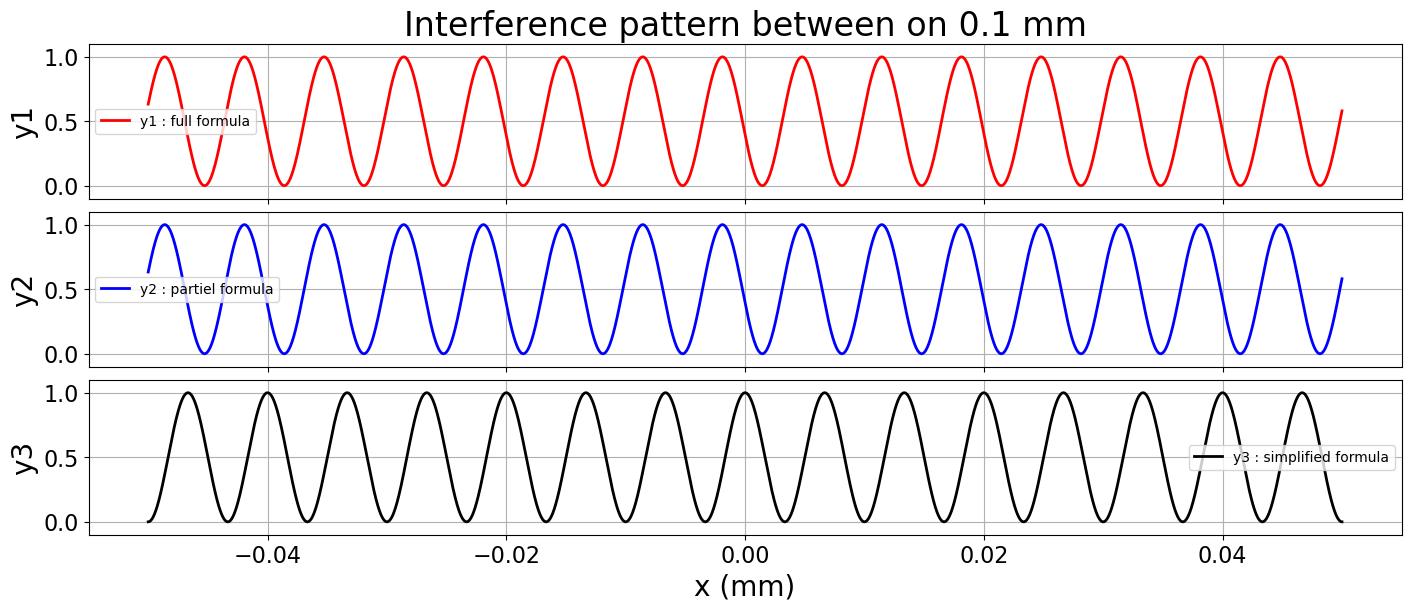

In [5]:
x = np.linspace(-.05,0.05,5000)*u.mm
y1 = InterferenceModule1D_1_A(x,WLR,C,DPSI) 
y2 = InterferenceModule1D_2_A(x,WLR,C,DPSI) 
y3 = InterferenceModule1D_3_A(x,WLR,C,DPSI)

fig,(ax1,ax2,ax3)  = plt.subplots(3,1,figsize=(14,6),layout="constrained",sharex=True,sharey=True)
ax1.plot(x,y1,'r',label = "y1 : full formula")
ax2.plot(x,y2,'b',label = "y2 : partiel formula")
ax3.plot(x,y3,'k',label = "y3 : simplified formula")
ax1.grid(); ax1.legend()
ax2.grid(); ax2.legend()
ax3.grid(); ax3.legend()


ax1.set_title("Interference pattern between on 0.1 mm")
ax3.set_xlabel("x (mm)")
ax1.set_ylabel("y1")
ax2.set_ylabel("y2")
ax3.set_ylabel("y3")
ax1.set_ylim(-0.1,1.1)
plt.show()

## Optical depth

- Perhaps should change the name because it is homogenous to an optical length

$$
\Delta (E_{rec}(x,\lambda_R)) = \frac{\Delta_{max}(\lambda_R) }{ 1 + \exp\{ -\gamma\left(\frac{E_{rec}(x)-E_0 }{E_0}\right)\}}
$$

## delta_max

<>:9: SyntaxWarning: invalid escape sequence '\,'
<>:9: SyntaxWarning: invalid escape sequence '\,'
/var/folders/79/hrybm_4s0zjd4jsb7lp_trhh0000gp/T/ipykernel_16259/3855349360.py:9: SyntaxWarning: invalid escape sequence '\,'
  ax.set_title("$\\Delta_{max} \, vs  \, \\lambda$ ")


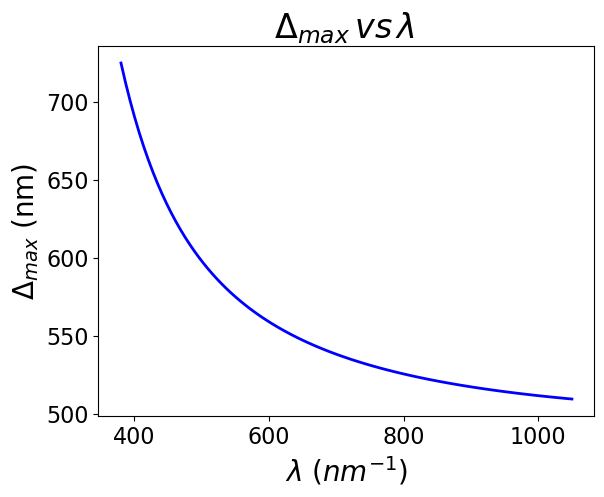

In [6]:
wlmin=380.*u.nm
wlmax = 1050.*u.nm
wlrange = np.linspace(wlmin,wlmax,100)
deltamax = deltamaxvslambda(wlrange)
fig,ax = plt.subplots(1,1)
ax.plot(wlrange,deltamax,"-b")
ax.set_xlabel("$\\lambda$ ($nm^{-1}$)")
ax.set_ylabel("$\\Delta_{max}$ (nm)")
ax.set_title("$\\Delta_{max} \, vs  \, \\lambda$ ")
plt.show()

### Transmission
$$
t(x,\lambda) = \exp\left\{i 2\pi \frac{\Delta E_{rec}(x,\lambda_R)}{\lambda}\right\}
$$

Text(0.5, 1.0, 'Hologram phase modulation over 0.1 mm mm')

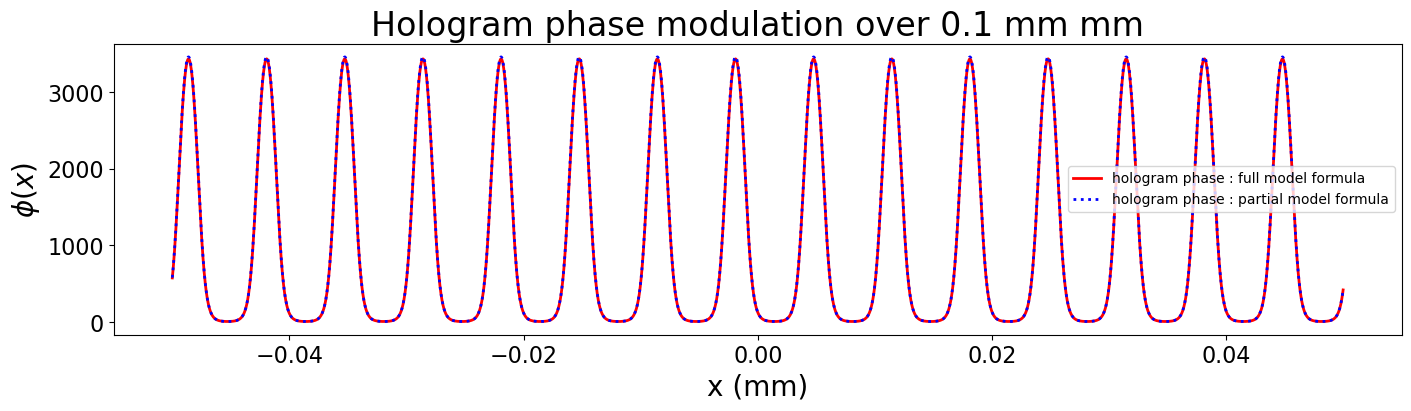

In [7]:
NPOINTS = 10000
x = np.linspace(-.05,0.05,NPOINTS)*u.mm 
delta_x = x.max()-x.min()
dx = np.diff(x).mean()
y_holo_ph_1A = Holo_Phase_1A(x,WL,DELTAMAX)
y_holo_ph_2A = Holo_Phase_2A(x,WL,DELTAMAX)
y_holo_ph_3A = Holo_Phase_3A(x,WL,DELTAMAX)

fig,ax  = plt.subplots(1,1,figsize=(14,4),layout="constrained",sharex=True)
ax.plot(x,y_holo_ph_1A,'-r',label = "hologram phase : full model formula")
ax.plot(x,y_holo_ph_2A,':b',label = "hologram phase : partial model formula")
ax.set_xlabel("x (mm)")
ax.set_ylabel("$\\phi(x)$")
ax.legend()
ax.set_title(f"Hologram phase modulation over {delta_x} mm")

## FFT 1D

### Parameters of the FFT

In [8]:
#Nb = 10001
#Nb = 20001
Nb = 100001
padding_factor = 1.5

#### The xe sampling

In [9]:
# x in units of mm
xe = np.linspace(-BEAM_RADIUS*padding_factor,+BEAM_RADIUS*padding_factor,Nb)
dxe = np.diff(xe).mean()
fe = 1/dxe
fmax = fe/2

In [10]:
print(f"Sampling distance dxe = {dxe}")
print(f"Sampling frequency fe = {fe:.3f}")
print(f"Max signal requency fmax = {fmax:.3f} before aliasing")
print(f"Beam radius = {BEAM_RADIUS}")
print(f"Beam radius frequency = {1/BEAM_RADIUS}")

Sampling distance dxe = 0.00015 mm
Sampling frequency fe = 6666.667 1 / mm
Max signal requency fmax = 3333.333 1 / mm before aliasing
Beam radius = 5.0 mm
Beam radius frequency = 0.2 1 / mm


#### The input aperture

In [11]:
ap = set_beam_aperture(xe)

Text(0.5, 0, 'beam-radius')

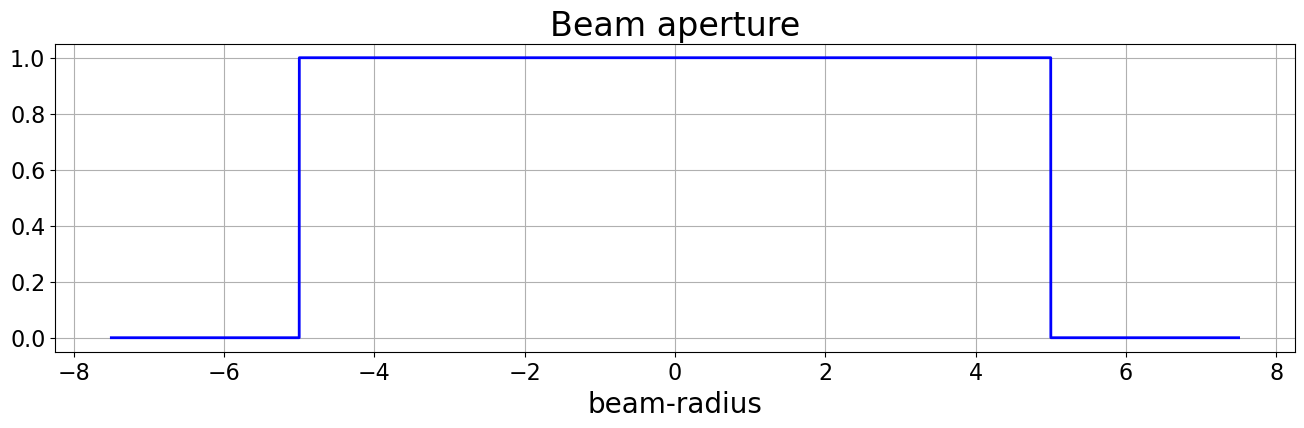

In [12]:
fig,ax = plt.subplots(1,1,figsize=(16,4))
x = xe
y = ap
ax.plot(x,y,'b-')
ax.grid()
ax.set_title(f"Beam aperture")
ax.set_xlabel("beam-radius")

#### The signals

In [13]:
y1 = holo_transmission_1A(xe,WL,deltamaxvslambda(WL),wlr=WLR,c=C0,dpsi=DPSI0)
y2 = holo_transmission_2A(xe,WL,deltamaxvslambda(WL),wlr=WLR,c=C0,dpsi=DPSI0)
y3 = holo_transmission_3A(xe,WL,deltamaxvslambda(WL),wlr=WLR,c=C0,dpsi=DPSI0)

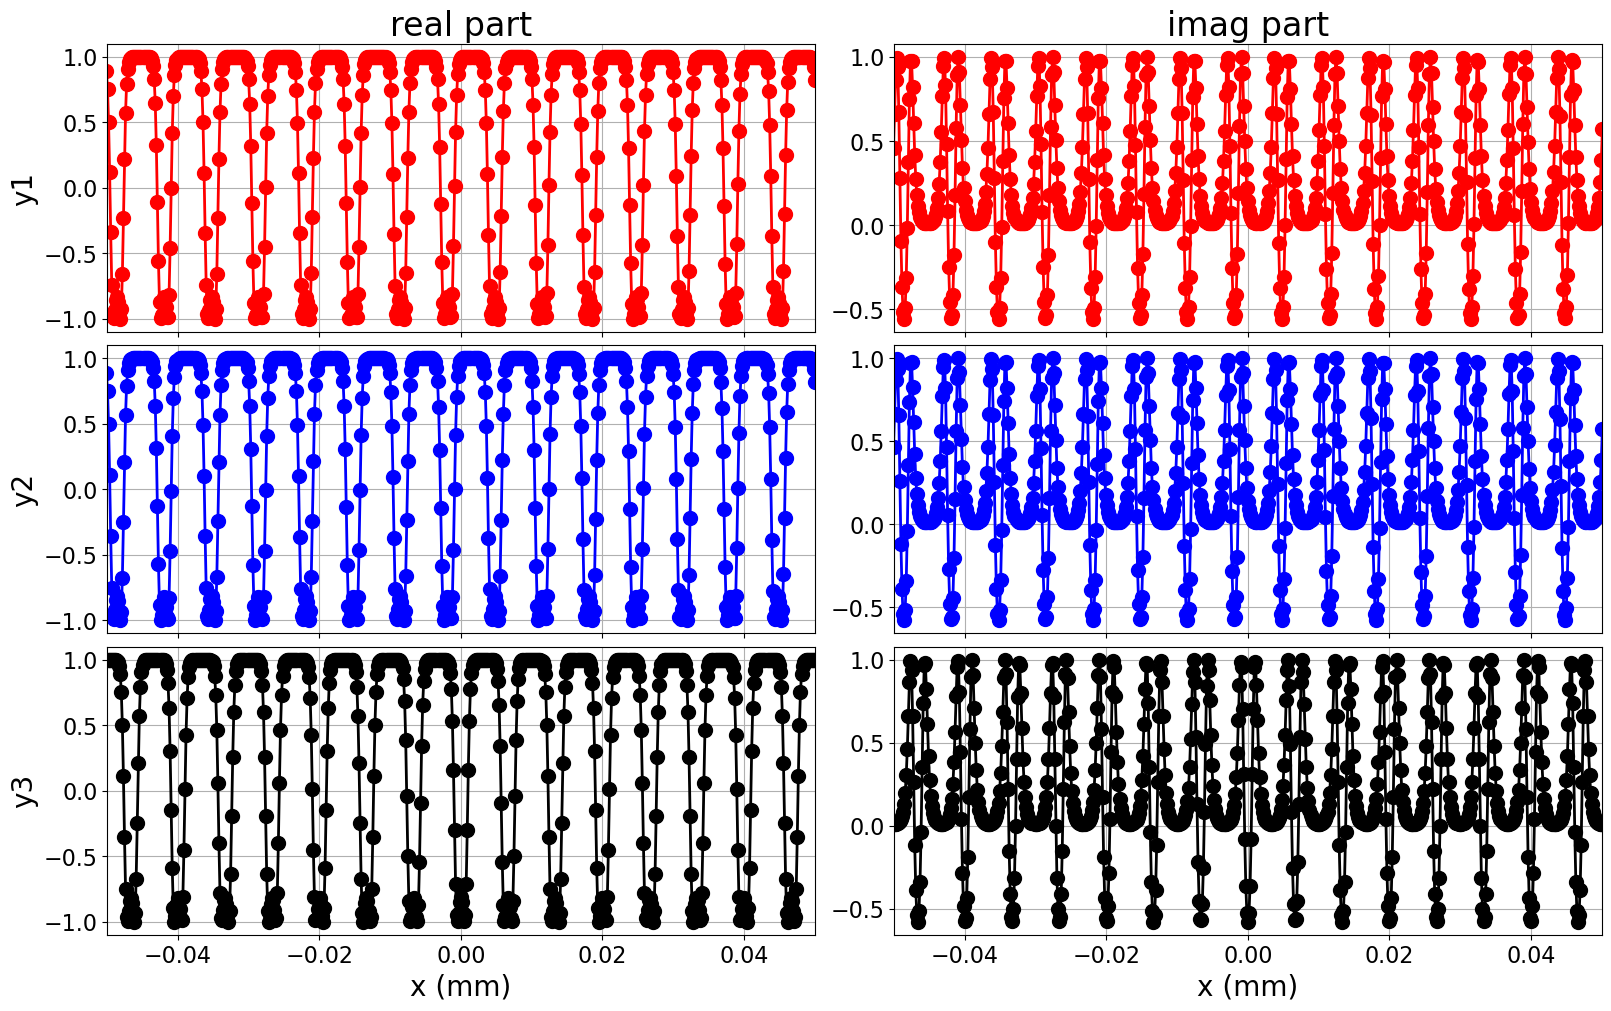

In [14]:
fig,axs = plt.subplots(3,2,figsize=(16,10),layout="constrained",sharex=True)
ax1,ax2,ax3,ax4,ax5,ax6 = axs.flatten()
ax1.plot(xe,y1.real,"o-r")
ax2.plot(xe,y1.imag,"o-r")
ax1.set_title("real part")
ax2.set_title("imag part")
ax1.set_ylabel("y1")


ax3.plot(xe,y2.real,"o-b")
ax4.plot(xe,y2.imag,"o-b")
ax3.set_ylabel("y2")

ax5.plot(xe,y3.real,"o-k")
ax6.plot(xe,y3.imag,"o-k")
ax5.set_ylabel("y3")
ax5.set_xlabel("x (mm)")
ax6.set_xlabel("x (mm)")

ax1.set_xlim(-0.05,0.05)
ax1.grid()
ax2.grid()
ax3.grid()
ax4.grid()
ax5.grid()
ax6.grid()

### FFT for the beam with the optical element in place : Phase Hologram

In [15]:
# beam without HOE
freqa,reala,imaga,modulea,phasea = ComputeFFT(ap,dxe=dxe/(u.mm))
# beam with HOE
freq1,real1,imag1,module1,phase1 = ComputeFFT(y1,dxe=dxe/(u.mm))
freq2,real2,imag2,module2,phase2 = ComputeFFT(y2,dxe=dxe/(u.mm))
freq3,real3,imag3,module3,phase3 = ComputeFFT(y3,dxe=dxe/(u.mm))

### Order 1 and order 2 components

In [16]:
# compute the spatial frequency where the order 1 and 2 are
f_order1 = NEFF/(1/u.mm)
f_order2 = 2*NEFF/(1/u.mm)
f_order3 = 3*NEFF/(1/u.mm)

print(f"fequency orders : fo1 = {f_order1} mm-1, fo2 = {f_order2} mm-1 , fo3 = {f_order3} mm-1")

fequency orders : fo1 = 150.0 mm-1, fo2 = 300.0 mm-1 , fo3 = 450.0 mm-1


In [17]:
def plot_orders_regions(ax,fmax,df=(1/BEAM_RADIUS)/(1/u.mm)):
    """
    
    """
    ax.axvline(x=df,c="pink",ls=":",label="order 0")
    ax.axvline(x=-df,c="pink",ls=":")

    if f_order1 < fmax:
        ax.axvline(x=f_order1+df,ls = ":",color="purple",label="order 1")
        ax.axvline(x=f_order1-df,ls = ":",color="purple")
        ax.axvline(x=-f_order1-df,ls = ":",color="purple")
        ax.axvline(x=-f_order1+df,ls = ":",color="purple")
       
    if f_order2 < fmax:
        ax.axvline(x=f_order2+df,ls = ":",color="cyan",label="order 2")
        ax.axvline(x=f_order2-df,ls = ":",color="cyan")
        ax.axvline(x= - f_order2-df,ls = ":",color="cyan")
        ax.axvline(x= - f_order2+df,ls = ":",color="cyan")

## Plot FFT components
- a) real part
- b) imaginary part
- c) module
- d) phase

## Choose wat to plot

In [18]:
FLAG_FULL_INTERF = True
FLAG_PARTIAL_INTERF = False
FLAG_SIMPLE_INTERF = False

if FLAG_FULL_INTERF:
    freq,real,imag,module,phase  = freq1,real1,imag1,module1,phase1 
    tag = "full true interference pattern"
elif FLAG_PARTIAL_INTERF:
    freq,real,imag,module,phase  = freq2,real2,imag2,module2,phase2
    tag = "approximate interference pattern"
else:
    freq,real,imag,module,phase  = freq3,real3,imag3,module3,phase3
    tag = "oversimplified interference pattern"

In [19]:
type(freq)

numpy.ndarray

In [20]:
type(real)

numpy.ndarray

In [21]:
type(module)

numpy.ndarray

In [22]:
fmax

<Quantity 3333.33333333 1 / mm>

In [23]:
def plotFFT(freq,real,imag,module,phase,fmax):
    """
    """
    fig,(ax1,ax2,ax3,ax4) = plt.subplots(4,1,figsize=(16,16),sharex=True)

    ax1.plot(freq, real, 'b',lw=3, label = "real")
    ax1.grid()
    plot_orders_regions(ax1,fmax)

    ax2.plot(freq, imag, 'r',lw=3, label = "imag")
    plot_orders_regions(ax2,fmax)
    ax2.grid()

    ax3.plot(freq, module, c='magenta',lw=3, label = "mod")
    plot_orders_regions(ax3,fmax)
    ax3.grid()

    ax4.plot(freq, convert_angle_to_mpi_ppi_interval(phase),'.g',lw=3, label = "phase")
    plot_orders_regions(ax4,fmax)
    ax4.grid()
    ax4.set_xlabel("frequency in mm$^{-1}$")


    ax1.legend()
    ax1.set_ylabel("FFT real")
    ax2.legend()
    ax2.set_ylabel("FFT imag")
    ax3.legend()
    ax3.set_ylabel("FFT mod")
    ax4.legend()
    ax4.set_ylabel("FFT phase")
    return ax1

In [24]:
freq

array([-3333.30000033, -3333.23333433, -3333.16666833, ...,
        3333.16666833,  3333.23333433,  3333.30000033])

Text(0.5, 1.0, 'FFT of HOE for full true interference pattern ')

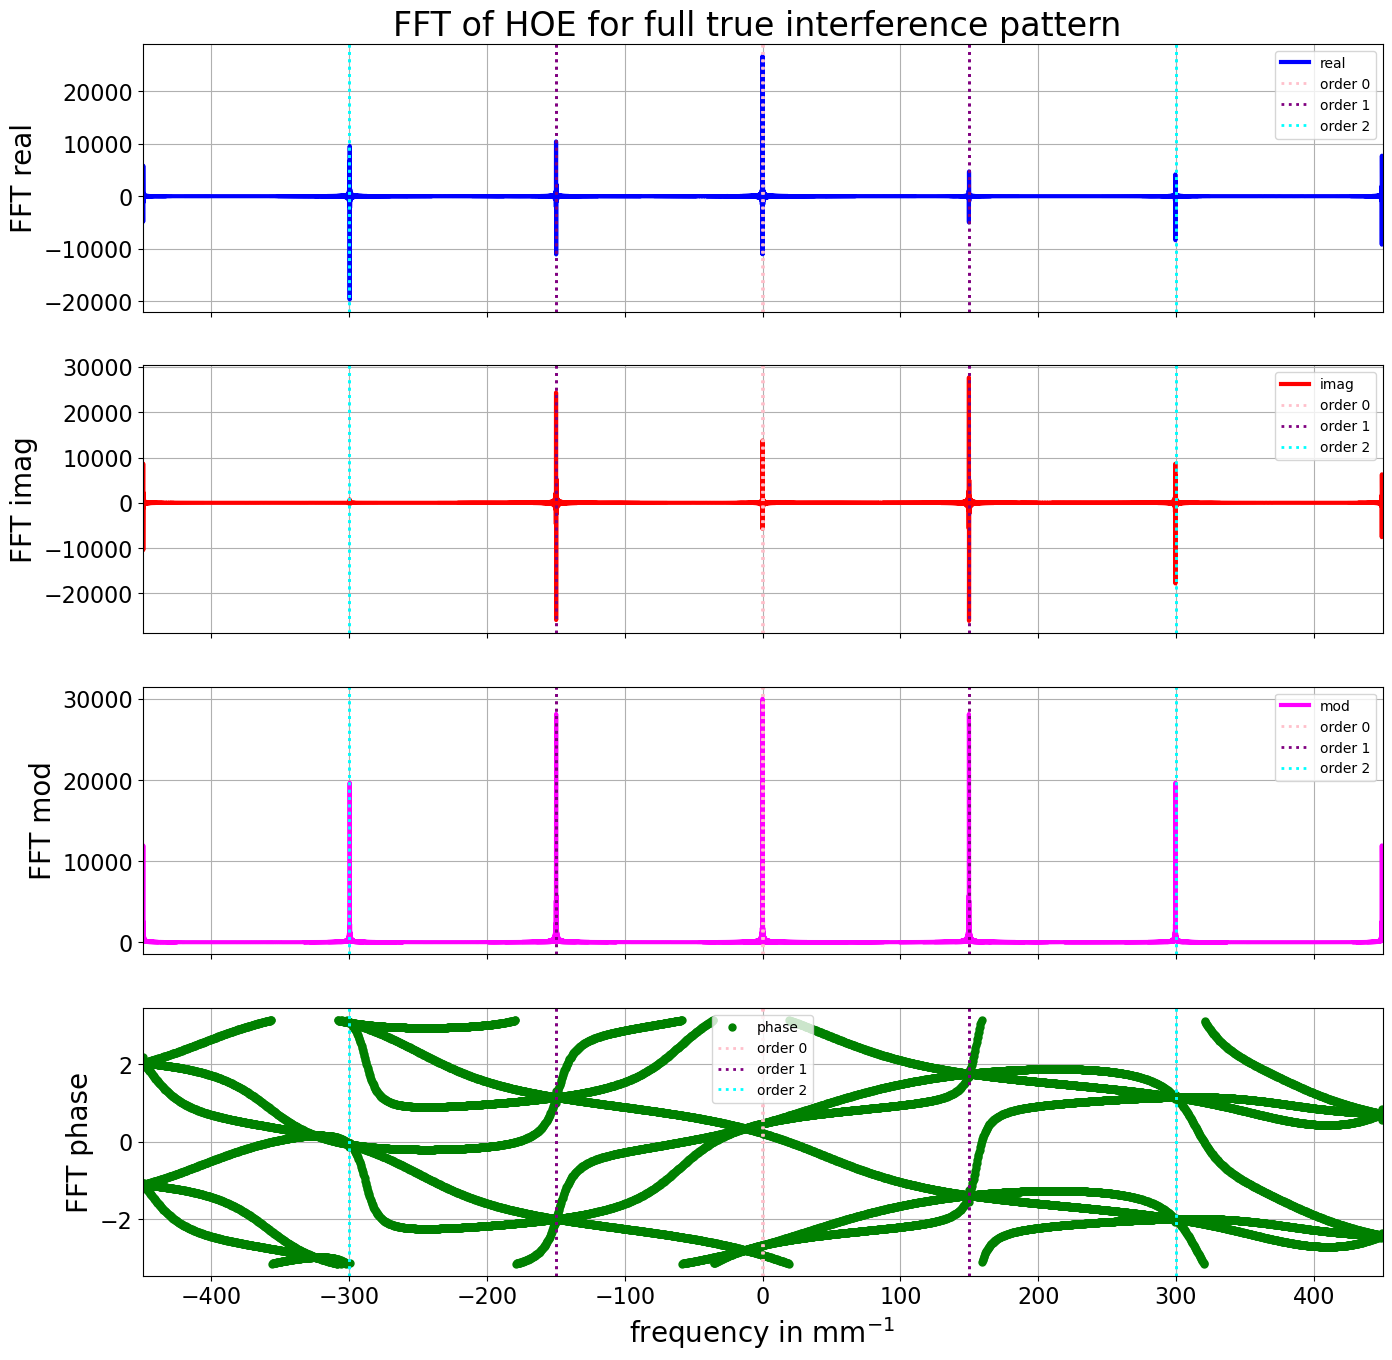

In [25]:
ax = plotFFT(freq,real,imag,module,phase,fmax=fmax/(1/u.mm))
ax.set_xlim(-f_order3,f_order3)
ax.set_title(f"FFT of HOE for {tag} ")

Text(0.5, 1.0, 'FFT of y3 : simplified interference pattern')

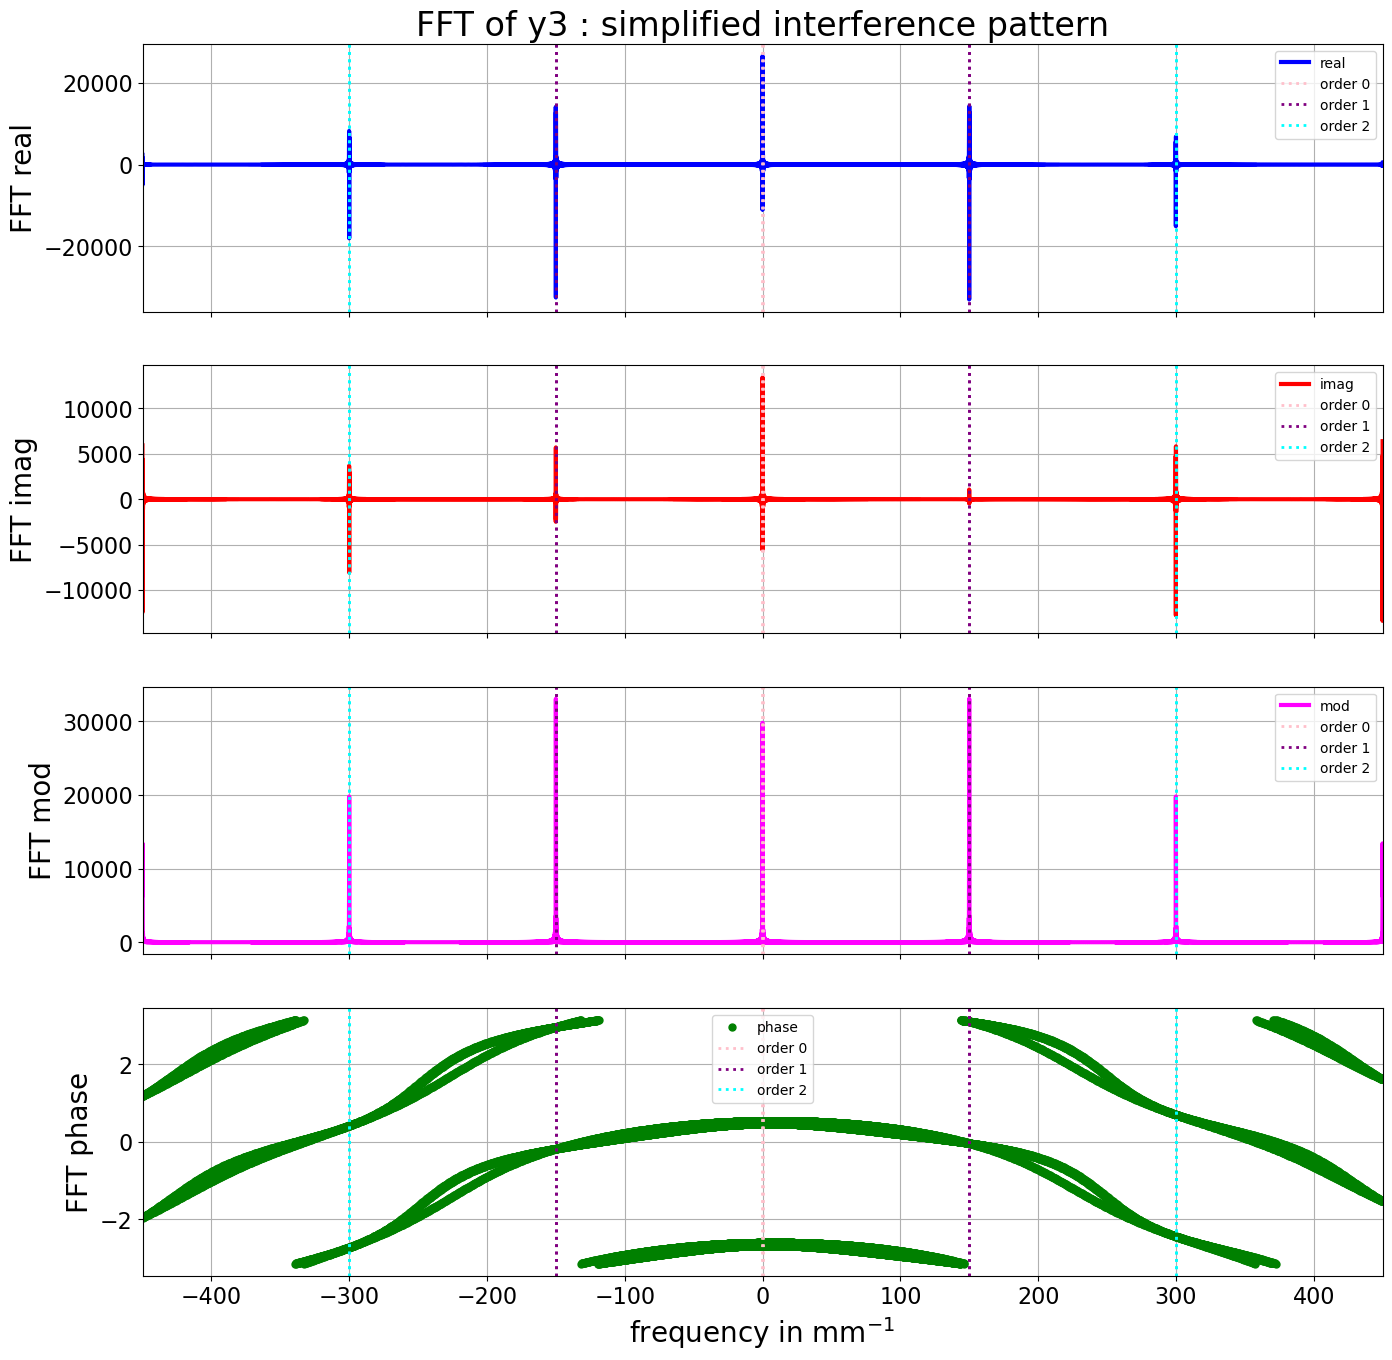

In [26]:
ax = plotFFT(freq3,real3,imag3,module3,phase3,fmax=fmax/(1/u.mm))
ax.set_xlim(-f_order3,f_order3)
ax.set_title("FFT of y3 : simplified interference pattern")

#### Plot the FFT coefficients in the aperture diffractive region

In [27]:
print(f"Beam radius = {BEAM_RADIUS}")
print(f"Beam radius frequency = {1/BEAM_RADIUS}")

Beam radius = 5.0 mm
Beam radius frequency = 0.2 1 / mm


Text(0.5, 1.0, 'full true interference pattern: First Fourier components (order -1)')

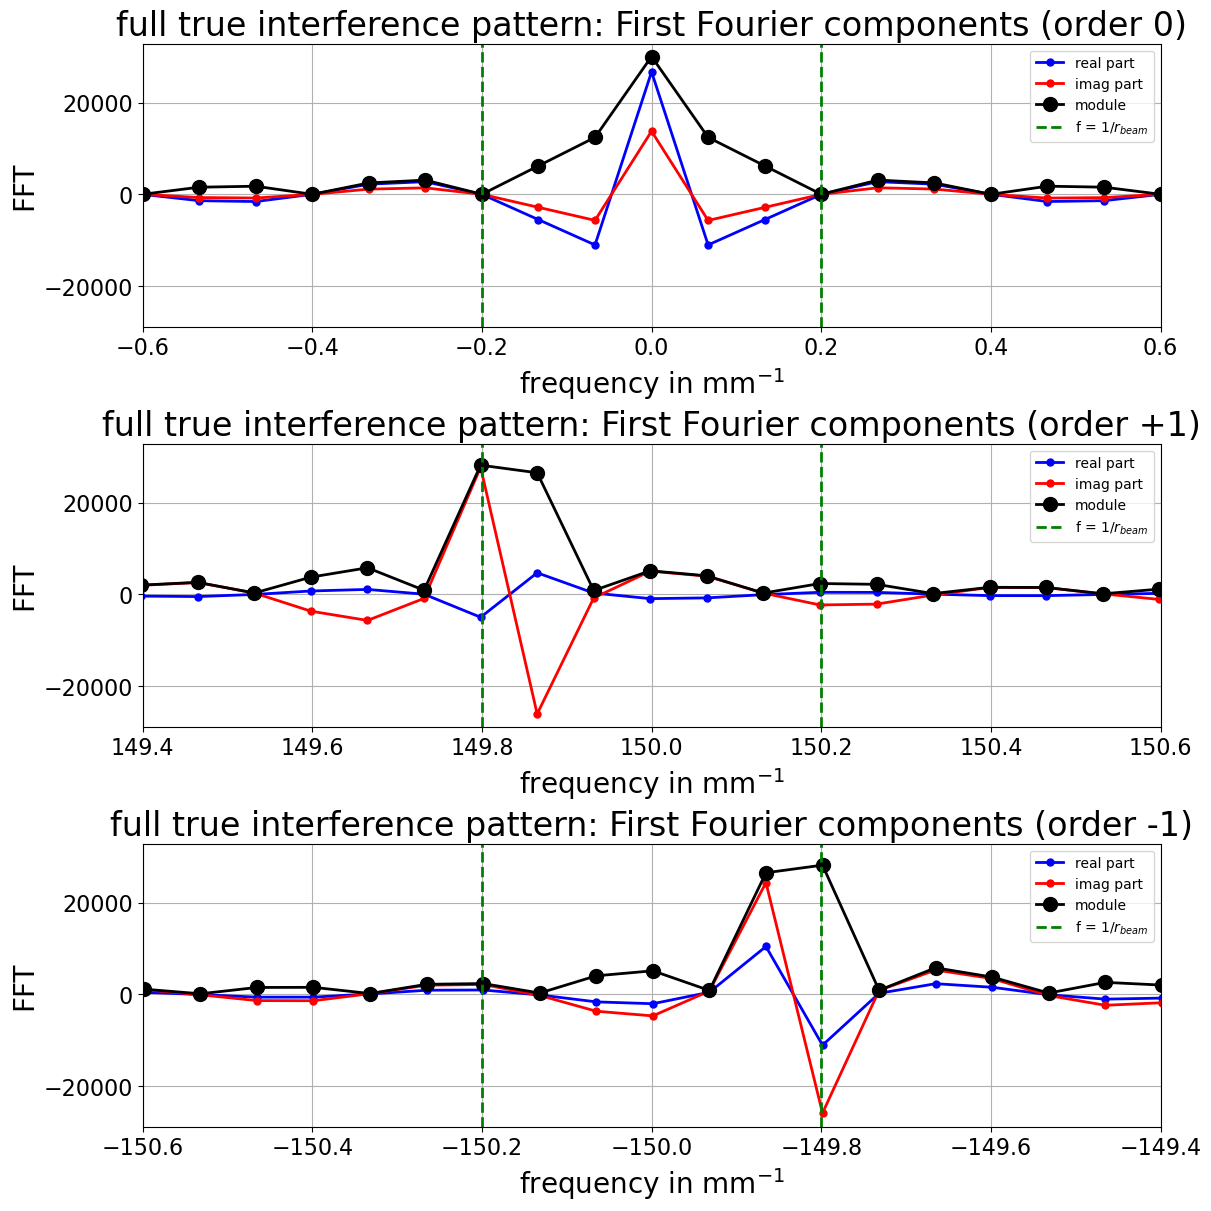

In [28]:
fig,(ax1,ax2,ax3)  = plt.subplots(3,1,figsize=(12,12),layout="constrained")

DF = (3*1/BEAM_RADIUS)/(1/u.mm)

ax1.plot(freq,real,marker=".",c="b",label="real part")
ax1.plot(freq,imag,marker=".",c="r",label="imag part")
ax1.plot(freq,module,marker="o",c="k",label="module")
ax1.set_ylabel("FFT")
ax1.set_xlim(-DF,DF)

ax1.set_xlabel("frequency in mm$^{-1}$")
ax1.axvline(x=1/BEAM_RADIUS*u.mm,c="g",ls="--",label="f = $1/r_{beam}$")
ax1.axvline(x=-1/BEAM_RADIUS*u.mm,c="g",ls="--")
ax1.grid()
ax1.legend()
ax1.set_title(f"{tag}: First Fourier components (order 0)")


ax2.plot(freq,real,marker=".",c="b",label="real part")
ax2.plot(freq,imag,marker=".",c="r",label="imag part")
ax2.plot(freq,module,marker="o",c="k",label="module")
ax2.set_ylabel("FFT")
ax2.set_xlim( f_order1 -DF , f_order1+ DF)

ax2.set_xlabel("frequency in mm$^{-1}$")
ax2.axvline(x=f_order1 + 1/BEAM_RADIUS*u.mm,c="g",ls="--",label="f = $1/r_{beam}$")
ax2.axvline(x=f_order1 -1/BEAM_RADIUS*u.mm,c="g",ls="--")
ax2.grid()
ax2.legend()
ax2.set_title(f"{tag}: First Fourier components (order +1)")


ax3.plot(freq,real,marker=".",c="b",label="real part")
ax3.plot(freq,imag,marker=".",c="r",label="imag part")
ax3.plot(freq,module,marker="o",c="k",label="module")
ax3.set_ylabel("FFT")
ax3.set_xlim( -f_order1 -DF , -f_order1+ DF)

ax3.set_xlabel("frequency in mm$^{-1}$")
ax3.axvline(x=-f_order1 + 1/BEAM_RADIUS*u.mm,c="g",ls="--",label="f = $1/r_{beam}$")
ax3.axvline(x=-f_order1 -1/BEAM_RADIUS*u.mm,c="g",ls="--")
ax3.grid()
ax3.legend()
ax3.set_title(f"{tag}: First Fourier components (order -1)")



In [29]:
DF = 5*1/BEAM_RADIUS*u.mm
indexes_order_0 = np.where(np.abs(freq)<DF)[0]
indexes_order_p1 = np.where(np.abs(freq-f_order1)<DF)[0]
indexes_order_m1 = np.where(np.abs(freq+f_order1)<DF)[0]

Text(0.5, 0.98, 'full true interference pattern: Coefficients of FFT around order 0')

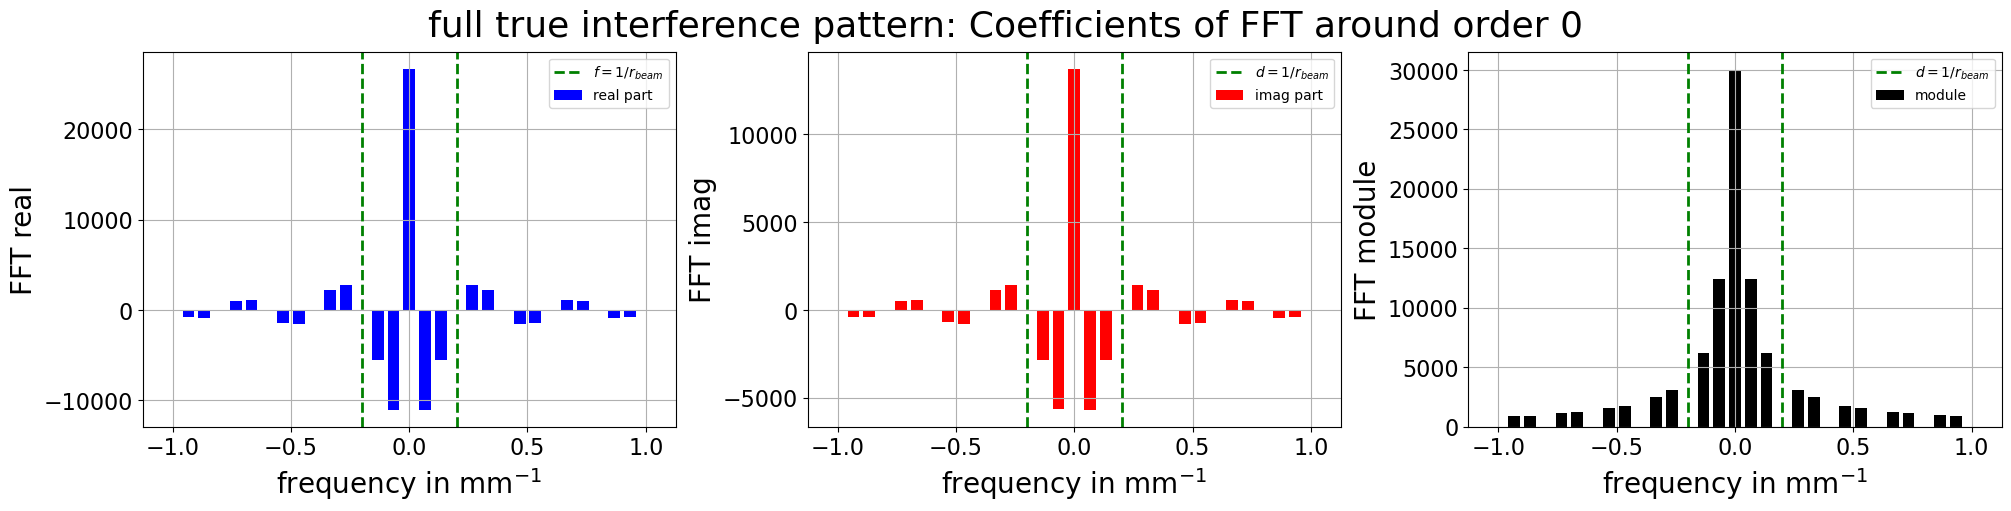

In [30]:
fig,(ax1,ax2,ax3) = plt.subplots(1,3,figsize=(20,5),sharex=True,layout="constrained")
ax1.bar(freq[indexes_order_0],real[indexes_order_0],width=0.05,facecolor="b",label="real part")
ax2.bar(freq[indexes_order_0],imag[indexes_order_0],width=0.05,facecolor="r",label="imag part")
ax3.bar(freq[indexes_order_0],module[indexes_order_0],width=0.05,facecolor="k",label="module")
ax1.set_ylabel("FFT real")
ax2.set_ylabel("FFT imag")
ax3.set_ylabel("FFT module")

ax1.axvline(x=1/BEAM_RADIUS*u.mm  ,c="g",ls="--",label="$f = 1/r_{beam}$")
ax2.axvline(x=1/BEAM_RADIUS*u.mm  ,c="g",ls="--",label="$d = 1/r_{beam}$")
ax3.axvline(x=1/BEAM_RADIUS*u.mm  ,c="g",ls="--",label="$d = 1/r_{beam}$")

ax1.axvline(x=-1/BEAM_RADIUS*u.mm  ,c="g",ls="--")
ax2.axvline(x=-1/BEAM_RADIUS*u.mm  ,c="g",ls="--")
ax3.axvline(x=-1/BEAM_RADIUS*u.mm  ,c="g",ls="--")

ax3.set_xlabel("frequency in mm$^{-1}$")
ax2.set_xlabel("frequency in mm$^{-1}$")
ax1.set_xlabel("frequency in mm$^{-1}$")
ax1.grid(); ax1.legend()
ax2.grid(); ax2.legend()
ax3.grid(); ax3.legend()
plt.suptitle(f"{tag}: Coefficients of FFT around order 0",fontsize=26)

Text(0.5, 0.98, 'full true interference pattern:Coefficients of FFT around order 1')

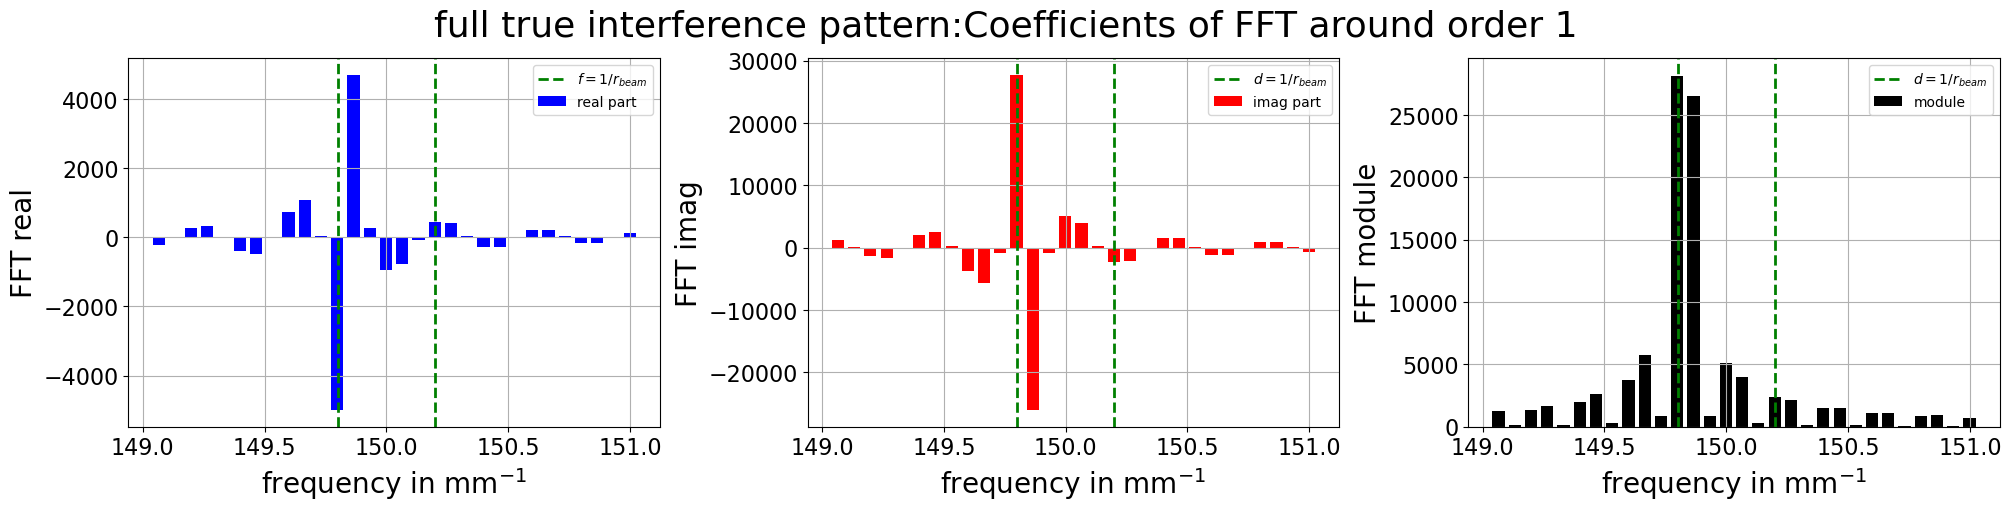

In [31]:
fig,(ax1,ax2,ax3) = plt.subplots(1,3,figsize=(20,5),sharex=True,layout="constrained")
ax1.bar(freq[indexes_order_p1],real[indexes_order_p1],width=0.05,facecolor="b",label="real part")
ax2.bar(freq[indexes_order_p1],imag[indexes_order_p1],width=0.05,facecolor="r",label="imag part")
ax3.bar(freq[indexes_order_p1],module[indexes_order_p1],width=0.05,facecolor="k",label="module")
ax1.set_ylabel("FFT real")
ax2.set_ylabel("FFT imag")
ax3.set_ylabel("FFT module")

ax1.axvline(x=1/BEAM_RADIUS*u.mm + f_order1 ,c="g",ls="--",label="$f = 1/r_{beam}$")
ax2.axvline(x=1/BEAM_RADIUS*u.mm + f_order1 ,c="g",ls="--",label="$d = 1/r_{beam}$")
ax3.axvline(x=1/BEAM_RADIUS*u.mm + f_order1 ,c="g",ls="--",label="$d = 1/r_{beam}$")

ax1.axvline(x=-1/BEAM_RADIUS*u.mm + f_order1 ,c="g",ls="--")
ax2.axvline(x=-1/BEAM_RADIUS*u.mm + f_order1 ,c="g",ls="--")
ax3.axvline(x=-1/BEAM_RADIUS*u.mm + f_order1 ,c="g",ls="--")

ax3.set_xlabel("frequency in mm$^{-1}$")
ax2.set_xlabel("frequency in mm$^{-1}$")
ax1.set_xlabel("frequency in mm$^{-1}$")
ax1.grid(); ax1.legend()
ax2.grid(); ax2.legend()
ax3.grid(); ax3.legend()
plt.suptitle(f"{tag}:Coefficients of FFT around order 1",fontsize=26)

Text(0.5, 0.98, 'full true interference pattern:Coefficients of FFT around order -1')

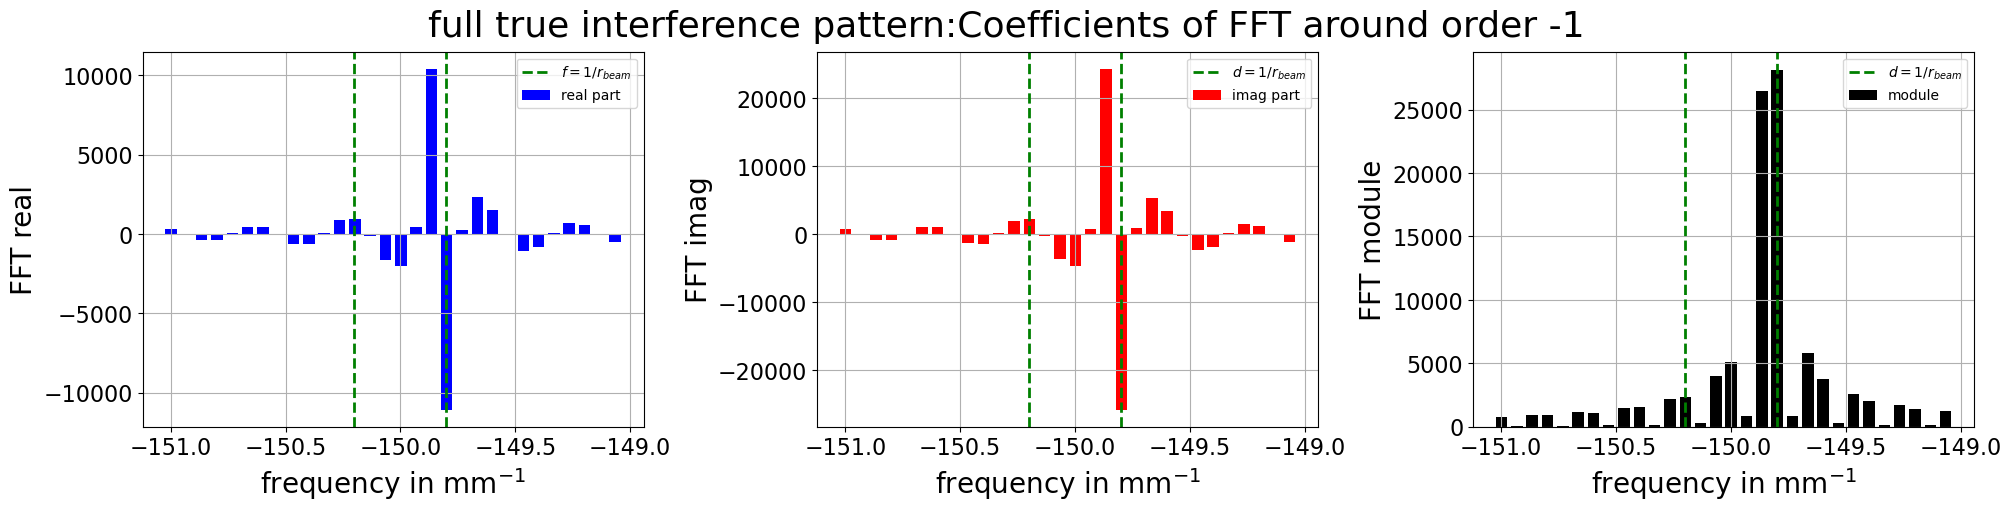

In [32]:
fig,(ax1,ax2,ax3) = plt.subplots(1,3,figsize=(20,5),sharex=True,layout="constrained")
ax1.bar(freq[indexes_order_m1],real[indexes_order_m1],width=0.05,facecolor="b",label="real part")
ax2.bar(freq[indexes_order_m1],imag[indexes_order_m1],width=0.05,facecolor="r",label="imag part")
ax3.bar(freq[indexes_order_m1],module[indexes_order_m1],width=0.05,facecolor="k",label="module")
ax1.set_ylabel("FFT real")
ax2.set_ylabel("FFT imag")
ax3.set_ylabel("FFT module")

ax1.axvline(x=1/BEAM_RADIUS*u.mm - f_order1 ,c="g",ls="--",label="$f = 1/r_{beam}$")
ax2.axvline(x=1/BEAM_RADIUS*u.mm - f_order1 ,c="g",ls="--",label="$d = 1/r_{beam}$")
ax3.axvline(x=1/BEAM_RADIUS*u.mm - f_order1 ,c="g",ls="--",label="$d = 1/r_{beam}$")

ax1.axvline(x=-1/BEAM_RADIUS*u.mm - f_order1 ,c="g",ls="--")
ax2.axvline(x=-1/BEAM_RADIUS*u.mm - f_order1 ,c="g",ls="--")
ax3.axvline(x=-1/BEAM_RADIUS*u.mm - f_order1 ,c="g",ls="--")

ax3.set_xlabel("frequency in mm$^{-1}$")
ax2.set_xlabel("frequency in mm$^{-1}$")
ax1.set_xlabel("frequency in mm$^{-1}$")
ax1.grid(); ax1.legend()
ax2.grid(); ax2.legend()
ax3.grid(); ax3.legend()
plt.suptitle(f"{tag}:Coefficients of FFT around order -1",fontsize=26)

## Transmission efficiency

- calculation from the FFT

In [33]:
w_factor = 2.

In [34]:
indexesa_order_0 = np.where(np.abs(freqa)<w_factor/BEAM_RADIUS*u.mm)[0]
indexes_order_0 = np.where(np.abs(freq)<w_factor/BEAM_RADIUS*u.mm)[0]
indexes_order_p1 = np.where(np.abs(freq-f_order1)<w_factor/BEAM_RADIUS*u.mm)[0]
indexes_order_m1 = np.where(np.abs(freq+f_order1)<w_factor/BEAM_RADIUS*u.mm)[0]

In [35]:
coeffa_order_0 = modulea[indexesa_order_0]
coeff_order_0 = module[indexes_order_0]
coeff_order_p1 = module[indexes_order_p1]
coeff_order_m1 = module[indexes_order_m1]

In [36]:
efficiency_order0 = (coeff_order_0**2).sum()/(coeffa_order_0**2).sum()
efficiency_orderp1 = (coeff_order_p1**2).sum()/(coeffa_order_0**2).sum()
efficiency_orderm1 = (coeff_order_m1**2).sum()/(coeffa_order_0**2).sum()

In [37]:
print(f"FFT : Transmission efficiency of order 0 : {efficiency_order0:.4f}")
print(f"FFT : Transmission efficiency of order 1 : {efficiency_orderp1:.4f}")
print(f"FFT : Transmission efficiency of order -1 : {efficiency_orderm1:.4f}")

FFT : Transmission efficiency of order 0 : 0.2028
FFT : Transmission efficiency of order 1 : 0.2437
FFT : Transmission efficiency of order -1 : 0.2437


In [38]:
orderp1order0 = (coeff_order_p1**2).sum()/(coeff_order_0**2).sum()
orderm1order0 = (coeff_order_m1**2).sum()/(coeff_order_0**2).sum()

In [39]:
print(f"FFT : Transmission radio order +1/ order 0 : {orderp1order0:.4f}")
print(f"FFT : Transmission radio order -1/ order 0 : {orderm1order0:.4f}")

FFT : Transmission radio order +1/ order 0 : 1.2015
FFT : Transmission radio order -1/ order 0 : 1.2019


## Compute Fourier coefficients

- For real signal

- For $n=0$

$$
a_0 = \frac{1}{a} \int_{-a/2}^{a/2} t(x) dx
$$

- For $n>=1$ or $n <= -1$(better keep order 1 and -1 separately:
$$
a_n = \frac{1}{a} \int_{-a/2}^{a/2} t(x) \cos(2\pi n \frac{x}{a}) dx
$$
$$
b_n = \frac{1}{a} \int_{-a/2}^{a/2} t(x) \sin(2\pi n \frac{x}{a}) dx
$$
$$
c_n = \frac{1}{a} \int_{-a/2}^{a/2} t(x) \exp(2\pi n \frac{x}{a}) dx
$$

## Convert units in mm in order to compute dimensionless integrations

In [40]:
print(f" periodicity = {AH:.5f}")

 periodicity = 0.00667 mm


In [41]:
# convert in dimensionless
a = AH/u.mm

In [42]:
# dimensionless x-range assumed to be in mm 
xrange = np.linspace(-5*a,5*a,50000) 

In [43]:
def integrand_an_v0(x, n, a):
    return (set_beam_aperture(x,radius = BEAM_RADIUS/u.mm )*np.cos(2*np.pi*n*(x/a).to_value()))/a
def integrand_bn_v0(x, n, a):
    return (set_beam_aperture(x,radius =  BEAM_RADIUS/u.mm )*np.sin(2*np.pi*n*(x/a).to_value()))/a
def integrand_cn_v0(x, n, a):
    return (set_beam_aperture(x,radius =  BEAM_RADIUS/u.mm)*np.exp(2j*np.pi*n*(x/a).to_value()))/a

Text(0.5, 1.02, 'Fourier coefficients calculation for beam aperture')

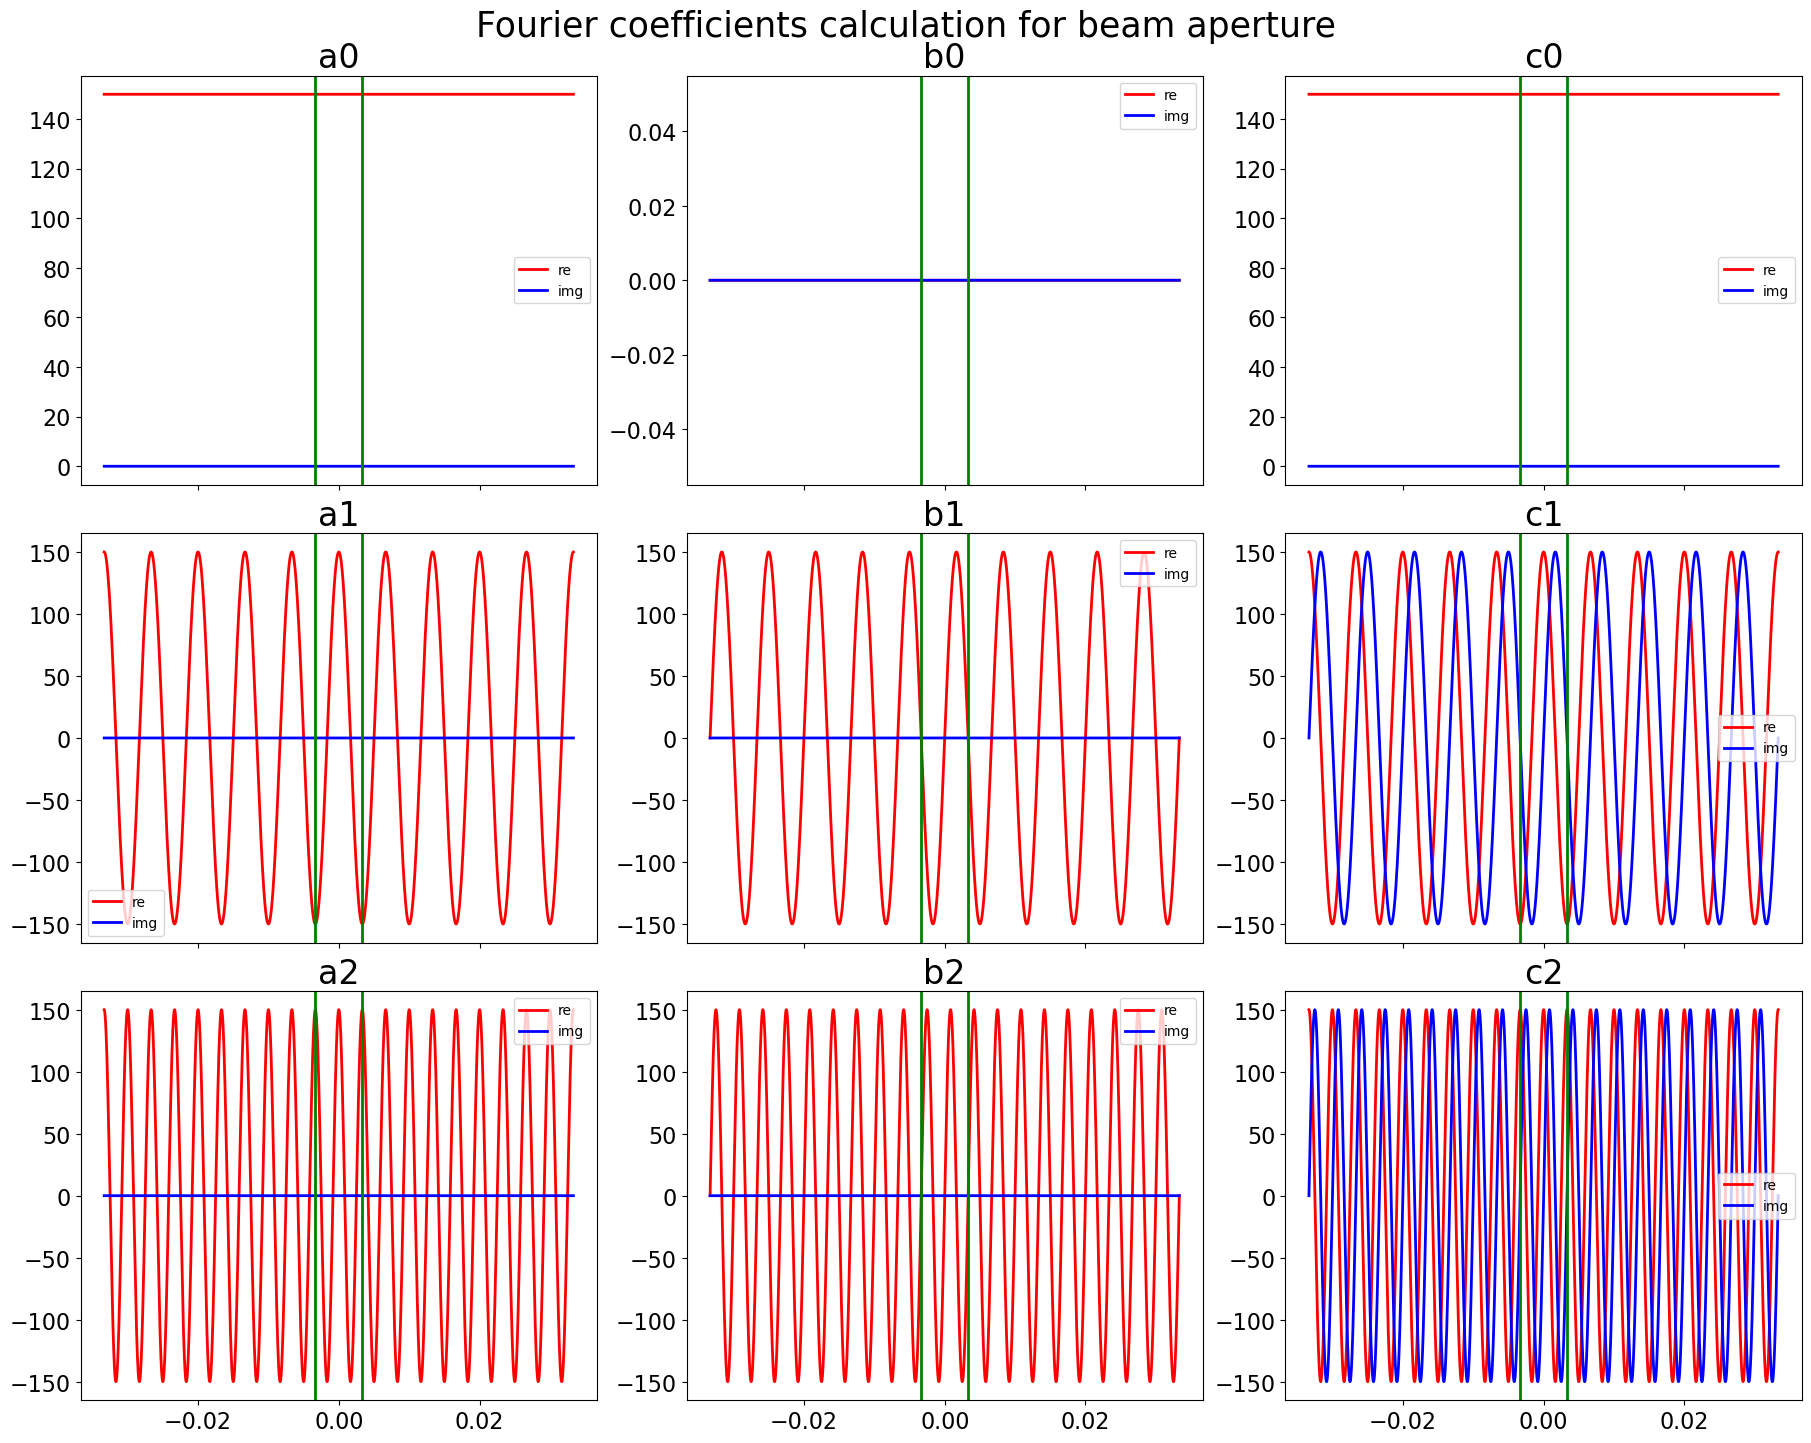

In [44]:
fig,axs = plt.subplots(3,3,figsize=(18,14),sharex=True,layout="constrained")
ax1,ax2,ax3,ax4,ax5,ax6,ax7,ax8,ax9 = axs.flatten()

y_a0 = integrand_an_v0(xrange, 0, a)
y_b0 = integrand_bn_v0(xrange, 0, a)
y_c0 = integrand_cn_v0(xrange, 0, a)

y_a1 = integrand_an_v0(xrange, 1, a)
y_b1 = integrand_bn_v0(xrange, 1, a)
y_c1 = integrand_cn_v0(xrange, 1, a)

y_a2 = integrand_an_v0(xrange, 2, a)
y_b2 = integrand_bn_v0(xrange, 2, a)
y_c2 = integrand_cn_v0(xrange, 2, a)

ax1.plot(xrange,y_a0.real,'r-',label="re")
ax1.plot(xrange,y_a0.imag,'b-',label="img")
ax1.set_title("a0")
ax1.axvline(-a/2,color="g")
ax1.axvline(a/2,color="g")
ax1.legend()

ax2.plot(xrange,y_b0.real,'r-',label="re")
ax2.plot(xrange,y_b0.imag,'b-',label="img")
ax2.set_title("b0")
ax2.axvline(-a/2,color="g")
ax2.axvline(a/2,color="g")
ax2.legend()

ax3.plot(xrange,y_c0.real,'r-',label="re")
ax3.plot(xrange,y_c0.imag,'b-',label="img")
ax3.set_title("c0")
ax3.axvline(-a/2,color="g")
ax3.axvline(a/2,color="g")
ax3.legend()

ax4.plot(xrange,y_a1.real,'r-',label="re")
ax4.plot(xrange,y_a1.imag,'b-',label="img")
ax4.set_title("a1")
ax4.axvline(-a/2,color="g")
ax4.axvline(a/2,color="g")
ax4.legend()

ax5.plot(xrange,y_b1.real,'r-',label="re")
ax5.plot(xrange,y_b1.imag,'b-',label="img")
ax5.set_title("b1")
ax5.axvline(-a/2,color="g")
ax5.axvline(a/2,color="g")
ax5.legend()

ax6.plot(xrange,y_c1.real,'r-',label="re")
ax6.plot(xrange,y_c1.imag,'b-',label="img")
ax6.set_title("c1")
ax6.axvline(-a/2,color="g")
ax6.axvline(a/2,color="g")
ax6.legend()


ax7.plot(xrange,y_a2.real,'r-',label="re")
ax7.plot(xrange,y_a2.imag,'b-',label="img")
ax7.set_title("a2")
ax7.axvline(-a/2,color="g")
ax7.axvline(a/2,color="g")
ax7.legend()


ax8.plot(xrange,y_b2.real,'r-',label="re")
ax8.plot(xrange,y_b2.imag,'b-',label="img")
ax8.set_title("b2")
ax8.axvline(-a/2,color="g")
ax8.axvline(a/2,color="g")
ax8.legend()


ax9.plot(xrange,y_c2.real,'r-',label="re")
ax9.plot(xrange,y_c2.imag,'b-',label="img")
ax9.set_title("c2")
ax9.axvline(-a/2,color="g")
ax9.axvline(a/2,color="g")
ax9.legend()

fig.suptitle(f"Fourier coefficients calculation for beam aperture",y=1.02,fontsize=25)

In [45]:
if FLAG_FULL_INTERF:
    def integrand_an_v2(x, n, a):
        return (np.cos(2*np.pi*n*(x/a).to_value())*holo_transmission_1A(x*u.mm,WL,deltamaxvslambda(WL),wlr=WLR,c=C0,dpsi=DPSI0))/a
    def integrand_bn_v2(x, n, a):
        return (np.sin(2*np.pi*n*(x/a).to_value())*holo_transmission_1A(x*u.mm,WL,deltamaxvslambda(WL),wlr=WLR,c=C0,dpsi=DPSI0))/a
    def integrand_cn_v2(x, n, a):
        return (np.exp(2j*np.pi*n*(x/a).to_value())*holo_transmission_1A(x*u.mm,WL,deltamaxvslambda(WL),wlr=WLR,c=C0,dpsi=DPSI0))/a
    
elif FLAG_PARTIAL_INTERF:
    def integrand_an_v2(x, n, a):
        return (np.cos(2*np.pi*n*(x/a).to_value())*holo_transmission_2A(x*u.mm,WL,deltamaxvslambda(WL),wlr=WLR,c=C0,dpsi=DPSI0))/a
    def integrand_bn_v2(x, n, a):
        return (np.sin(2*np.pi*n*(x/a).to_value())*holo_transmission_2A(x*u.mm,WL,deltamaxvslambda(WL),wlr=WLR,c=C0,dpsi=DPSI0))/a
    def integrand_cn_v2(x, n, a):
        return (np.exp(2j*np.pi*n*(x/a).to_value())*holo_transmission_2A(x*u.mm,WL,deltamaxvslambda(WL),wlr=WLR,c=C0,dpsi=DPSI0))/a
    
else:
    def integrand_an_v2(x, n, a):
        return (np.cos(2*np.pi*n*(x/a).to_value())*holo_transmission_3A(x*u.mm,WL,deltamaxvslambda(WL),wlr=WLR,c=C0,dpsi=DPSI0))/a
    def integrand_bn_v2(x, n, a):
        return (np.sin(2*np.pi*n*(x/a).to_value())*holo_transmission_3A(x*u.mm,WL,deltamaxvslambda(WL),wlr=WLR,c=C0,dpsi=DPSI0))/a
    def integrand_cn_v2(x, n, a):
        return (np.exp(2j*np.pi*n*(x/a).to_value())*holo_transmission_3A(x*u.mm,WL,deltamaxvslambda(WL),wlr=WLR,c=C0,dpsi=DPSI0))/a
    

Text(0.5, 1.02, 'full true interference pattern : Fourier series coefficients calculation')

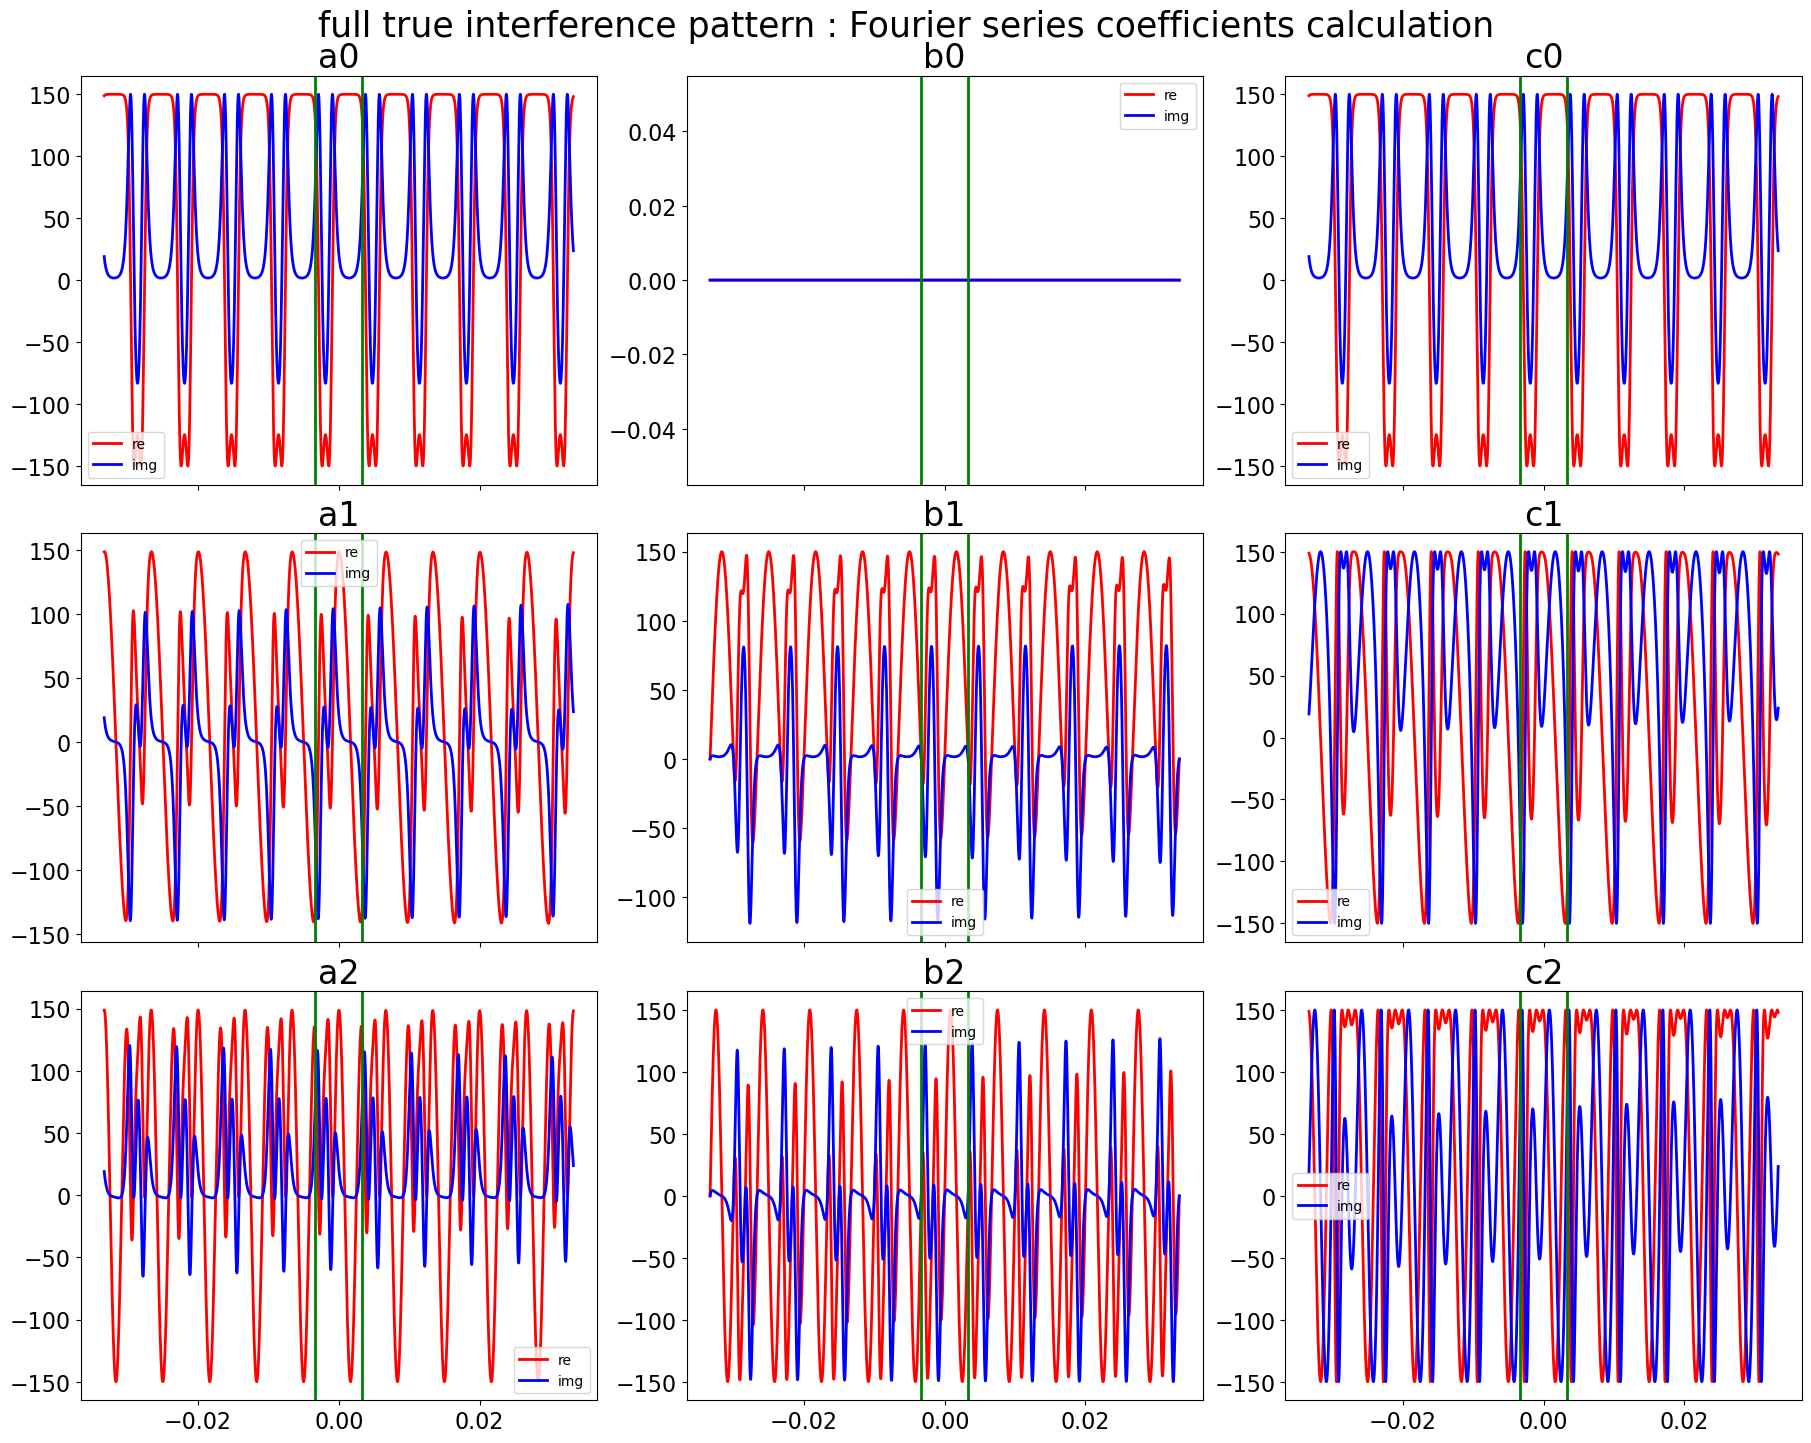

In [46]:
fig,axs = plt.subplots(3,3,figsize=(18,14),sharex=True,layout="constrained")
ax1,ax2,ax3,ax4,ax5,ax6,ax7,ax8,ax9 = axs.flatten()

y_a0 = integrand_an_v2(xrange, 0, a)
y_b0 = integrand_bn_v2(xrange, 0, a)
y_c0 = integrand_cn_v2(xrange, 0, a)

y_a1 = integrand_an_v2(xrange, 1, a)
y_b1 = integrand_bn_v2(xrange, 1, a)
y_c1 = integrand_cn_v2(xrange, 1, a)

y_a2 = integrand_an_v2(xrange, 2, a)
y_b2 = integrand_bn_v2(xrange, 2, a)
y_c2 = integrand_cn_v2(xrange, 2, a)

ax1.plot(xrange,y_a0.real,'r-',label="re")
ax1.plot(xrange,y_a0.imag,'b-',label="img")
ax1.set_title("a0")
ax1.axvline(-a/2,color="g")
ax1.axvline(a/2,color="g")
ax1.legend()

ax2.plot(xrange,y_b0.real,'r-',label="re")
ax2.plot(xrange,y_b0.imag,'b-',label="img")
ax2.set_title("b0")
ax2.axvline(-a/2,color="g")
ax2.axvline(a/2,color="g")
ax2.legend()

ax3.plot(xrange,y_c0.real,'r-',label="re")
ax3.plot(xrange,y_c0.imag,'b-',label="img")
ax3.set_title("c0")
ax3.axvline(-a/2,color="g")
ax3.axvline(a/2,color="g")
ax3.legend()

ax4.plot(xrange,y_a1.real,'r-',label="re")
ax4.plot(xrange,y_a1.imag,'b-',label="img")
ax4.set_title("a1")
ax4.axvline(-a/2,color="g")
ax4.axvline(a/2,color="g")
ax4.legend()

ax5.plot(xrange,y_b1.real,'r-',label="re")
ax5.plot(xrange,y_b1.imag,'b-',label="img")
ax5.set_title("b1")
ax5.axvline(-a/2,color="g")
ax5.axvline(a/2,color="g")
ax5.legend()

ax6.plot(xrange,y_c1.real,'r-',label="re")
ax6.plot(xrange,y_c1.imag,'b-',label="img")
ax6.set_title("c1")
ax6.axvline(-a/2,color="g")
ax6.axvline(a/2,color="g")
ax6.legend()


ax7.plot(xrange,y_a2.real,'r-',label="re")
ax7.plot(xrange,y_a2.imag,'b-',label="img")
ax7.set_title("a2")
ax7.axvline(-a/2,color="g")
ax7.axvline(a/2,color="g")
ax7.legend()


ax8.plot(xrange,y_b2.real,'r-',label="re")
ax8.plot(xrange,y_b2.imag,'b-',label="img")
ax8.set_title("b2")
ax8.axvline(-a/2,color="g")
ax8.axvline(a/2,color="g")
ax8.legend()


ax9.plot(xrange,y_c2.real,'r-',label="re")
ax9.plot(xrange,y_c2.imag,'b-',label="img")
ax9.set_title("c2")
ax9.axvline(-a/2,color="g")
ax9.axvline(a/2,color="g")
ax9.legend()
fig.suptitle(f"{tag} : Fourier series coefficients calculation",y=1.02,fontsize=25)

### Compute Fourier coefficients

#### Order zero coefficients

##### Order 0 for beam aperture only

In [47]:
a0_v0 = quad(integrand_an_v0, -a/2, a/2, args=(0,a))

In [48]:
a0_v0 = quad(integrand_an_v0, -a/2, a/2, args=(0,a))
b0_v0 = quad(integrand_bn_v0, -a/2, a/2, args=(0,a))
c0_v0 = quad(integrand_cn_v0, -a/2, a/2, args=(0,a))
# transform tuples from quad function in  complex numbers
a0_v1 = a0_v0[0] + 1j* a0_v0[1]
b0_v1 = b0_v0[0] + 1j* b0_v0[1]
c0_v1 = c0_v0[0] + 1j* c0_v0[1]
print(f"v1 : (a0,b0,c0) = ({a0_v1:.4f},{b0_v1:.4f}, {c0_v1:.4f})")

v1 : (a0,b0,c0) = (1.0000+0.0000j,0.0000+0.0000j, 1.0000+0.0000j)


/Users/dagoret/anaconda3/envs/poppy_py312/lib/python3.12/site-packages/astropy/units/quantity.py:1334: ComplexWarning: Casting complex values to real discards the imaginary part
  return float(self.to_value(dimensionless_unscaled))


##### Order 0 from HOE  in beam

In [49]:
a0_v2 = quad(integrand_an_v2, -a/2, a/2, args=(0,a))
b0_v2 = quad(integrand_bn_v2, -a/2, a/2, args=(0,a))
c0_v2 = quad(integrand_cn_v2, -a/2, a/2, args=(0,a))
# transform tuples from quad function in  complex numbers
a0_v3 = a0_v2[0] + 1j* a0_v2[1]
b0_v3 = b0_v2[0] + 1j* b0_v2[1]
c0_v3 = c0_v2[0] + 1j* c0_v2[1]
print(f"v3 : (a0,b0,c0) = ({a0_v3:.4f},{b0_v3:.4f}, {c0_v3:.4f})")

v3 : (a0,b0,c0) = (0.3998+0.0000j,0.0000+0.0000j, 0.3998+0.0000j)


- **Notice No order 0 in HOE**

#### Order 1 coefficients

##### Order 1 from  beam aperture

In [50]:
a1_v0 = quad(integrand_an_v0, -a/2, a/2, args=(1,a))
b1_v0 = quad(integrand_bn_v0, -a/2, a/2, args=(1,a))
c1_v0 = quad(integrand_cn_v0, -a/2, a/2, args=(1,a))
# transform tuples from quad function in  complex numbers
a1_v1 = a1_v0[0] + 1j* a1_v0[1]
b1_v1 = b1_v0[0] + 1j* b1_v0[1]
c1_v1 = c1_v0[0] + 1j* c1_v0[1]
print(f"v1 : (a1,b1,c1) = ({a1_v1:.4f},{b1_v1:.4f},{c1_v1:.4f})")

v1 : (a1,b1,c1) = (0.0000+0.0000j,0.0000+0.0000j,0.0000+0.0000j)


- **Notice No order 1 in aperture beam**

##### Order 1 from HOE  in beam

In [51]:
a1_v2 = quad(integrand_an_v2, -a/2, a/2, args=(1,a))
b1_v2 = quad(integrand_bn_v2, -a/2, a/2, args=(1,a))
c1_v2 = quad(integrand_cn_v2, -a/2, a/2, args=(1,a))

# transform tuples in  complex numbers
a1_v3 = a1_v2[0] + 1j* a1_v2[1]
b1_v3 = b1_v2[0] + 1j* b1_v2[1]
c1_v3 = c1_v2[0] + 1j* c1_v2[1]
print(f"v3 : (a1,b1,c1) = ({a1_v3:.4f},{b1_v3:.4f},{c1_v3:.4f})")

v3 : (a1,b1,c1) = (0.1063+0.0000j,0.4815+0.0000j,0.1609+0.0000j)


- **Note Presence of order 1 in HOE**

#### Other Orders n>=2 coefficients

In [52]:
sum_supp2_ab = 0
sum_supp2_c = 0

for n in range(2,10):
    an = quad(integrand_an_v0, -a/2, a/2, args=(n,a))
    bn = quad(integrand_bn_v0, -a/2, a/2, args=(n,a))
    cn = quad(integrand_cn_v0, -a/2, a/2, args=(n,a))
    
    # convert tuple into complex number
    an_v0 = an[0]+ 1j*an[1]
    bn_v0 = bn[0]+ 1j*bn[1]
    cn_v0 = cn[0]+ 1j*cn[1]

    sum_supp2_ab += np.absolute(an_v0)**2 + np.absolute(bn_v0)**2 
    sum_supp2_c += np.absolute(cn_v0)**2 
print(sum_supp2_ab,sum_supp2_c)

1.6161981168912064e-18 1.6161980523142357e-18


- **Notice no other orders $n\ge2$ in aperture beam**

In [53]:
sum_supp2_v2_ab = 0
sum_supp2_v2_c = 0
for n in range(2,10):
    an = quad(integrand_an_v2, -a/2, a/2, args=(n,a))
    bn = quad(integrand_bn_v2, -a/2, a/2, args=(n,a))
    cn = quad(integrand_cn_v2, -a/2, a/2, args=(n,a))
    
    # convert tuple into complex number
    an_v2 = an[0]+ 1j*an[1]
    bn_v2 = bn[0]+ 1j*bn[1]
    cn_v2 = cn[0]+ 1j*cn[1]
    
    sum_supp2_v2_ab += np.absolute(an_v2)**2 + np.absolute(bn_v2)**2 
    sum_supp2_v2_c += np.absolute(cn_v2)**2 
print(sum_supp2_v2_ab,sum_supp2_v2_c)

0.07619124156444362 0.11272120290819623


 **Notice Very small contribution of other orders $n\ge2$ in HOE**

### Transmission efficiency and order ratio

- with respect to no HOE in beam

#### Efficiency

In [54]:
c0_v1

(1.0000000000000002+1.1102230246251569e-14j)

In [55]:
c1_v3

(0.1608937624968292+2.2907655417689683e-12j)

In [56]:
# ratio when the HOE in place wrt with beam aperture
efficiency_order0 = np.absolute(c0_v3)**2/np.absolute(c0_v1)**2 
efficiency_orderp1 = np.absolute(c1_v3)**2/np.absolute(c0_v1)**2 
efficiency_orderm1 = np.absolute(c1_v3)**2/np.absolute(c0_v1)**2 

In [57]:
print(f"Fourier Coeff : Transmission efficiency of order 0 : {efficiency_order0:.4f}")
print(f"Fourier Coeff : Transmission efficiency of order 1 : {efficiency_orderp1:.4f}")
print(f"Fourier Coeff : Transmission efficiency of order -1 : {efficiency_orderm1:.4f}")

Fourier Coeff : Transmission efficiency of order 0 : 0.1598
Fourier Coeff : Transmission efficiency of order 1 : 0.0259
Fourier Coeff : Transmission efficiency of order -1 : 0.0259


In [58]:
efficiency_order0_v2 = np.absolute(c0_v3)**2/(np.absolute(c0_v3)**2 + 2*(np.absolute(c1_v3))**2 + 2*sum_supp2_v2_c)
efficiency_orderp1_v2 = np.absolute(c1_v3)**2/(np.absolute(c0_v3)**2 + 2*(np.absolute(c1_v3))**2 + 2*sum_supp2_v2_c)
efficiency_orderm1_v2 =  np.absolute(c1_v3)**2/(np.absolute(c0_v3)**2 + 2*(np.absolute(c1_v3))**2 + 2*sum_supp2_v2_c)

In [59]:
print(f"Fourier Coeff : v2 : Transmission efficiency of order 0 : {efficiency_order0_v2:.4f}")
print(f"Fourier Coeff : v2 : Transmission efficiency of order 1 : {efficiency_orderp1_v2:.4f}")
print(f"Fourier Coeff : v2 : Transmission efficiency of order -1 : {efficiency_orderm1_v2:.4f}")

Fourier Coeff : v2 : Transmission efficiency of order 0 : 0.3657
Fourier Coeff : v2 : Transmission efficiency of order 1 : 0.0592
Fourier Coeff : v2 : Transmission efficiency of order -1 : 0.0592


#### Order ratio

In [60]:
orderp1order0_v2 = np.absolute(c1_v3)**2/np.absolute(c0_v3)**2
orderm1order0_v2 = np.absolute(c1_v3)**2/np.absolute(c0_v3)**2

In [61]:
print(f"Fourier Coeff : v2 : Transmission radio order +1/ order 0 : {orderp1order0_v2:.4f}")
print(f"Fourier Coeff : v2 : Transmission radio order -1/ order 0 : {orderm1order0_v2:.4f}")

Fourier Coeff : v2 : Transmission radio order +1/ order 0 : 0.1620
Fourier Coeff : v2 : Transmission radio order -1/ order 0 : 0.1620
